We'll use the famous MNIST Handwritten Digits Database as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9), along with labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist](https://i.imgur.com/CAYnuo1.jpg)

In [5]:
import torch
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Download training dataset
dataset = MNIST(root ="data/" , download = True)

100.1%

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw


113.5%

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw


100.4%

Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw


180.4%C:\Users\mohda\anaconda3\envs\torch_env\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw
Processing...
Done!


In [3]:
len(dataset)

60000

The dataset has 60,000 images which can be used to train the model. There is also an additonal test set of 10,000 images which can be created by passing ```train=False``` to the MNIST class.

In [4]:
test_dataset = MNIST(root = 'data/',train=False)
len(test_dataset)

10000

Label:  5


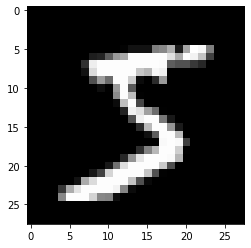

In [8]:
image, label = dataset[0]
plt.imshow(image,cmap='gray')
print('Label: ', label)

It's evident that these images are quite small in size, and recognizing the digits can sometimes be hard even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [9]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions which are applied to the images as they are loaded. ```torchvision.transforms``` contains many such predefined functions, and we'll use the ```ToTensor``` transform to convert images into PyTorch tensors.

In [10]:
dataset = MNIST(root='data/',train=True,transform=transforms.ToTensor())

In [11]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


### Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. Training set - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.

2. Validation set - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.

3. Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.


In the MNIST dataset, there are 60,000 training images, and 10,000 test images. The test set is standardized so that different researchers can report the results of their models against the same set of images.

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the ```random_spilt``` method from PyTorch.

In [13]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset,[50000, 10000])

len(train_ds), len(val_ds)

(50000, 10000)

In [14]:
from torch.utils.data import DataLoader

In [16]:
batch_size = 128

train_loader = DataLoader(train_ds,batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size)

We set ```shuffle=True``` for the training dataloader, so that the batches generated in each epoch are different, and this randomization helps generalize & speed up the training process. On the other hand, since the validation dataloader is used only for evaluating the model, there is no need to shuffle the images.

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model i.e. there are weights and bias matrices, and the output is obtained using simple matrix operations ```(pred = x @ w.t() + b)```.

* Just as we did with linear regression, we can use nn.Linear to create the model instead of defining and initializing the matrices manually.

* Since nn.Linear expects the each training example to be a vector, each 1x28x28 image tensor needs to be flattened out into a vector of size 784 (28*28), before being passed into the model.

* The output for each image is vector of size 10, with each element of the vector signifying the probability a particular target label (i.e. 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [17]:
import torch.nn as nn
input_size = 28*28
num_classes = 10

model = nn.Linear(input_size,num_classes)

In [18]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0216, -0.0226,  0.0030,  ...,  0.0009,  0.0283,  0.0208],
        [-0.0079, -0.0034, -0.0183,  ..., -0.0258, -0.0272,  0.0272],
        [ 0.0032, -0.0317, -0.0356,  ..., -0.0111, -0.0326, -0.0090],
        ...,
        [ 0.0164,  0.0063, -0.0132,  ..., -0.0201, -0.0203,  0.0035],
        [-0.0235,  0.0114,  0.0352,  ...,  0.0072,  0.0181, -0.0188],
        [ 0.0145, -0.0228, -0.0258,  ...,  0.0289, -0.0072, -0.0098]],
       requires_grad=True)

In [19]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0322, -0.0219, -0.0286,  0.0231,  0.0119, -0.0226,  0.0241,  0.0256,
        -0.0226,  0.0215], requires_grad=True)

In [20]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    break

tensor([2, 3, 2, 8, 1, 2, 1, 4, 0, 4, 6, 8, 7, 8, 3, 9, 1, 5, 7, 2, 1, 3, 1, 8,
        0, 8, 0, 9, 8, 1, 8, 0, 6, 6, 2, 5, 1, 2, 7, 7, 1, 1, 3, 4, 3, 4, 5, 5,
        0, 2, 0, 3, 4, 4, 1, 7, 9, 6, 8, 7, 6, 2, 2, 3, 9, 3, 3, 5, 1, 1, 7, 1,
        0, 5, 1, 6, 9, 8, 1, 3, 1, 3, 2, 6, 1, 0, 3, 7, 6, 6, 4, 0, 4, 6, 5, 3,
        2, 6, 9, 5, 2, 4, 2, 9, 5, 3, 7, 0, 2, 7, 0, 4, 0, 9, 2, 5, 6, 2, 8, 1,
        9, 1, 2, 1, 3, 0, 4, 3])
torch.Size([128, 1, 28, 28])


RuntimeError: size mismatch, m1: [3584 x 28], m2: [784 x 10] at ..\aten\src\TH/generic/THTensorMath.cpp:41

This leads to an error, because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784 i.e. we need to flatten them out. We'll use the ```.reshape``` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector, without really chaging the underlying data.

To include this additional functionality within our model, we need to define a custom model, by extending the ```nn.Module``` class from PyTorch.

In [21]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,num_classes)
    
    def forward(self,xb):
        xb = xb.reshape(-1,784)
        out = self.linear(xb)
        return out

model = MnistModel()

Inside the ```__init__``` constructor method, we instantiate the weights and biases using ```nn.Linear```. And inside the ```forward``` method, which is invoked when we pass a batch of inputs to the model, we flatten out the input tensor, and then pass it into ```self.linear```.

```xb.reshape(-1, 28*28)``` indicates to PyTorch that we want a view of the ```xb``` tensor with two dimensions, where the length along the 2nd dimension is 28*28 (i.e. 784). One argument to ```.reshape``` can be set to ```-1``` (in this case the first dimension), to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has ```.weight``` and ```.bias``` attributes (as they are now inside the ```.linear``` attribute), but it does have a ```.parameters``` method which returns a list containing the weights and bias, and can be used by a PyTorch optimizer.

In [22]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0226,  0.0181, -0.0356,  ...,  0.0102,  0.0104,  0.0281],
         [ 0.0248, -0.0070,  0.0269,  ...,  0.0300,  0.0256,  0.0316],
         [ 0.0347, -0.0185,  0.0067,  ...,  0.0083, -0.0302, -0.0069],
         ...,
         [ 0.0308,  0.0291, -0.0098,  ...,  0.0199, -0.0227,  0.0335],
         [-0.0282, -0.0215,  0.0236,  ...,  0.0291,  0.0124,  0.0139],
         [-0.0048,  0.0006, -0.0260,  ..., -0.0181, -0.0128, -0.0107]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0244,  0.0295,  0.0319,  0.0104,  0.0026,  0.0333,  0.0107, -0.0291,
         -0.0172,  0.0318], requires_grad=True)]

In [23]:
for images,labels in train_loader:
    outputs = model(images)
    break
print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.4359,  0.3900, -0.0312,  0.0263, -0.1143,  0.0618, -0.0283,  0.1042,
         -0.1967, -0.0295],
        [-0.3567,  0.4774,  0.2834,  0.0465, -0.1330,  0.0011, -0.3604,  0.3524,
         -0.1840,  0.0426]])


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities, but for that the elements of each output row must lie between 0 to 1 and add up to 1, which is clearly not the case here.

To convert the output rows into probabilities, we use the softmax function, which has the following formula:
![softmax](https://i.imgur.com/EAh9jLN.png)

First we replace each element ```yi``` in an output row by ```e^yi```, which makes all the elements positive, and then we divide each element by the sum of all elements to ensure that they add up to 1.

While it's easy to implement the softmax function, we'll use the implementation that's provided within PyTorch, because it works well with multidimensional tensors (a list of output rows in our case).

In [26]:
import torch.nn.functional as F

In [28]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)
print(preds.shape)

tensor([1, 1, 2, 1, 7, 1, 4, 1, 1, 1, 3, 1, 1, 1, 2, 1, 9, 1, 1, 1, 3, 1, 5, 1,
        1, 1, 5, 3, 1, 4, 7, 1, 1, 1, 1, 1, 2, 9, 8, 7, 8, 1, 1, 1, 1, 1, 1, 1,
        1, 9, 7, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 6, 6, 7, 1, 3, 7, 3, 7, 1, 6,
        1, 1, 6, 1, 7, 1, 1, 1, 1, 9, 7, 1, 9, 1, 1, 1, 1, 1, 6, 7, 4, 5, 5, 3,
        1, 9, 9, 1, 5, 1, 1, 1, 7, 1, 1, 1, 1, 7, 1, 8, 9, 8, 2, 4, 1, 1, 1, 1,
        1, 1, 1, 7, 1, 5, 1, 1])
tensor([0.1484, 0.1527, 0.1245, 0.1316, 0.1529, 0.1679, 0.1191, 0.1415, 0.1215,
        0.1507, 0.1259, 0.1296, 0.1310, 0.1254, 0.1489, 0.1509, 0.1152, 0.1708,
        0.1521, 0.1343, 0.1117, 0.1317, 0.1426, 0.1521, 0.1197, 0.1596, 0.1170,
        0.1430, 0.1456, 0.1225, 0.1227, 0.1573, 0.1406, 0.1587, 0.1291, 0.1263,
        0.1293, 0.1204, 0.1345, 0.1316, 0.1156, 0.1490, 0.1342, 0.1370, 0.1412,
        0.1364, 0.1235, 0.1282, 0.1369, 0.1202, 0.1221, 0.1721, 0.1248, 0.1587,
        0.1601, 0.1199, 0.1355, 0.1297, 0.1501, 0.1427, 0.1377, 0.1190, 0.1199,
       

In [29]:
labels

tensor([4, 9, 5, 5, 9, 3, 8, 7, 3, 9, 6, 4, 8, 9, 5, 3, 1, 2, 3, 9, 3, 3, 0, 7,
        8, 7, 2, 0, 9, 6, 4, 0, 9, 0, 7, 3, 0, 1, 5, 9, 4, 0, 7, 0, 0, 8, 9, 6,
        7, 1, 4, 3, 9, 9, 8, 1, 4, 1, 9, 7, 5, 1, 0, 3, 6, 0, 1, 6, 2, 9, 0, 1,
        8, 3, 1, 6, 4, 2, 9, 9, 2, 1, 9, 8, 1, 2, 7, 0, 8, 9, 7, 8, 7, 3, 3, 3,
        5, 1, 1, 8, 0, 7, 5, 3, 3, 9, 0, 8, 8, 9, 5, 6, 1, 5, 4, 7, 8, 3, 4, 2,
        2, 9, 2, 3, 0, 1, 0, 7])

## Evaluation Metric and Loss Function

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the accuracy of the predictions.

In [40]:
def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

The == performs an element-wise comparison of two tensors with the same shape, and returns a tensor of the same shape, containing 0s for unequal elements, and 1s for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

Note that we don't need to apply softmax to the outputs, since it doesn't change the relative order of the results. This is because e^x is an increasing function i.e. if y1 > y2, then e^y1 > e^y2 and the same holds true after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model, on the first batch of data. Obviously, we expect it to be pretty bad.

In [41]:
accuracy(outputs, labels)

tensor(0.0234)

While the accuracy is a great way for us (humans) to evaluate the model, it can't be used as a loss function for optimizing our model using gradient descent, for the following reasons:

1. It's not a differentiable function. torch.max and == are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

Due to these reasons, accuracy is a great evaluation metric for classification, but not a good loss function. A commonly used loss function for classification problems is the cross entropy, which has the following formula:

![entrop](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are [0.1, 0.3, 0.2, ...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest.

* Then, take the logarithm of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the outputs of the model without converting them into probabilities.

In [42]:
loss_fn = F.cross_entropy
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3471, grad_fn=<NllLossBackward>)


Since the cross entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples, one way to interpret the resulting number e.g. 2.23 is look at e^-2.23 which is around 0.1 as the predicted probability of the correct label, on average. Lower the loss, better the model.

## Optimizer

In [43]:
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(),lr)

## Training the model

In [56]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,num_classes)
    def forward(self,xb):
        xb = xb.reshape(-1,784)
        out = self.linear(xb)
        return out
    
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss':loss, 'val_acc': acc}

    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss']for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() #combine loss
        batch_acc = [x['val_acc']for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean() # combine accuracies
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [72]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [76]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        #training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # validation pahse
        result = evaluate(model,val_loader)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [74]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.297684669494629, 'val_acc': 0.11431962251663208}

In [77]:
history1 = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9349, val_acc: 0.6065
Epoch [1], val_loss: 1.6697, val_acc: 0.7228
Epoch [2], val_loss: 1.4713, val_acc: 0.7635
Epoch [3], val_loss: 1.3212, val_acc: 0.7850
Epoch [4], val_loss: 1.2056, val_acc: 0.7967
Epoch [5], val_loss: 1.1146, val_acc: 0.8050
Epoch [6], val_loss: 1.0415, val_acc: 0.8121
Epoch [7], val_loss: 0.9817, val_acc: 0.8185
Epoch [8], val_loss: 0.9317, val_acc: 0.8243
Epoch [9], val_loss: 0.8896, val_acc: 0.8276


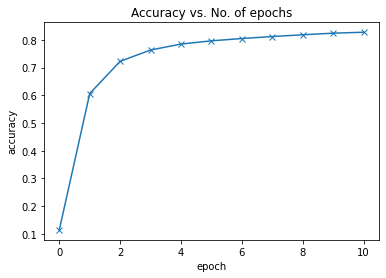

In [78]:
history = [result0] + history1
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Testing with individual images

In [79]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


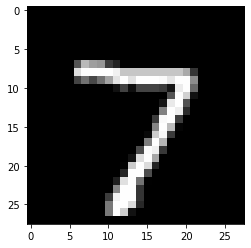

In [80]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [81]:
img.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

Let's define a helper function predict_image, which returns the predicted label for a single image tensor.

In [84]:
def predict_image(img,label):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _,preds = torch.max(yb,dim=1)
    return preds[0].item()

```img.unsqueeze``` simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

Label: 7 , Predicted: 7


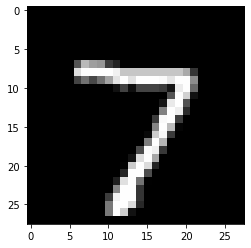

In [85]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


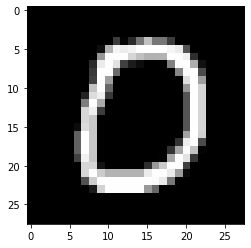

In [86]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [87]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.8623329401016235, 'val_acc': 0.8374999761581421}

## Saving and loading the model

In [88]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The ```.state_dict``` method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model.



In [89]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0246,  0.0234,  0.0281,  ...,  0.0353,  0.0269, -0.0145],
                      [ 0.0235,  0.0220, -0.0049,  ...,  0.0110,  0.0094, -0.0271],
                      [-0.0066,  0.0230, -0.0303,  ...,  0.0128, -0.0128, -0.0169],
                      ...,
                      [ 0.0076,  0.0283,  0.0182,  ...,  0.0312,  0.0348,  0.0286],
                      [-0.0317,  0.0085, -0.0333,  ...,  0.0062, -0.0191,  0.0149],
                      [ 0.0169,  0.0045,  0.0305,  ...,  0.0305,  0.0284,  0.0333]])),
             ('linear.bias',
              tensor([-0.0096,  0.0341, -0.0283, -0.0059,  0.0138, -0.0096,  0.0200,  0.0017,
                      -0.0304, -0.0292]))])